<a href="https://colab.research.google.com/github/PiriTnz/edu-mkdocs/blob/master/combine%202images%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving style_style.jpg to style_style.jpg


In [2]:
from google.colab import files
uploaded = files.upload()

Saving style_contenu.jpg to style_contenu.jpg


In [3]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [4]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    size = max(max_size, max(image.size)) if max(image.size) > max_size else max(image.size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    image = in_transform(image)[:3, :, :].unsqueeze(0)  # add batch dimension
    return image

In [5]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    return image

In [6]:
# Load VGG19 model
vgg = models.vgg19(pretrained=True).features

# Freeze model parameters
for param in vgg.parameters():
    param.requires_grad_(False)

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 99.5MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

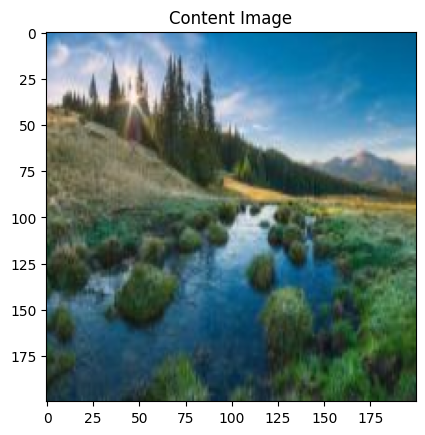

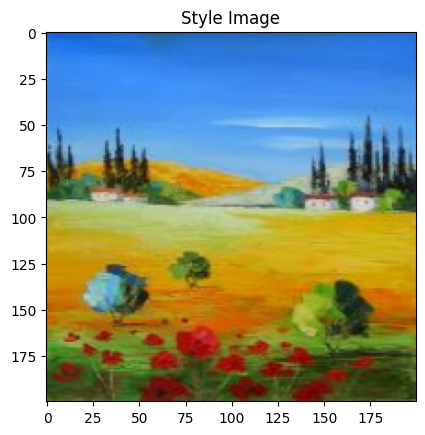

In [8]:
# Load content and style images using uploaded image names
content = load_image('style_contenu.jpg').to(device)
style = load_image('style_style.jpg', shape=content.shape[-2]).to(device)  # Estefade az yek adad baraye shape

# Show content and style images
plt.figure()
plt.imshow(im_convert(content))
plt.title("Content Image")
plt.show()

plt.figure()
plt.imshow(im_convert(style))
plt.title("Style Image")
plt.show()

In [9]:
# Get features from the VGG model
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # Content layer
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Extract features from content and style images
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [10]:
# Gram matrix calculation
def gram_matrix(tensor):
    _, d, h, w = tensor.size()  # d is depth (number of feature maps), h is height, w is width
    tensor = tensor.view(d, h * w)  # Flatten tensor
    gram = torch.mm(tensor, tensor.t())  # Matrix multiplication
    return gram

# Get the Gram matrices for each layer in the style image
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [11]:
# Create the target image as a copy of the content image
target = content.clone().requires_grad_(True).to(device)

# Define style weights for each layer
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.8,
                 'conv3_1': 0.6,
                 'conv4_1': 0.4,
                 'conv5_1': 0.2}

# Set content and style weights
content_weight = 1  # Alpha
style_weight = 1e6  # Beta

In [12]:
# Set up optimizer
optimizer = optim.Adam([target], lr=0.003)

Epoch 0, Total loss: 130088939028480.0


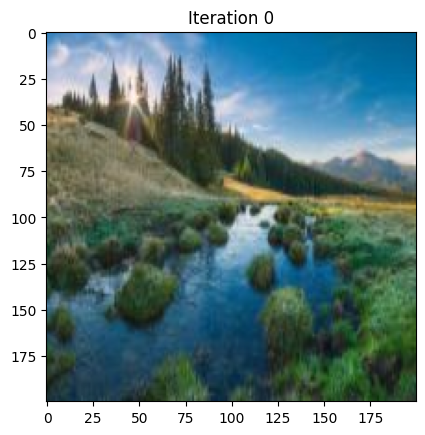

Epoch 50, Total loss: 67225088163840.0


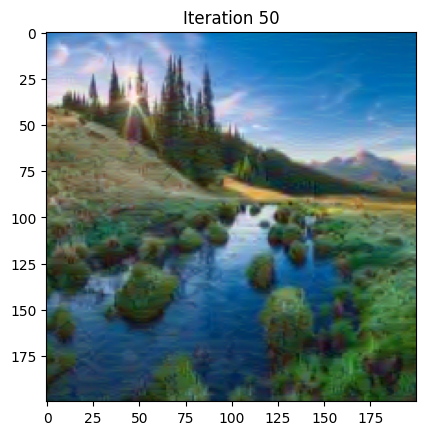

Epoch 100, Total loss: 40640524058624.0


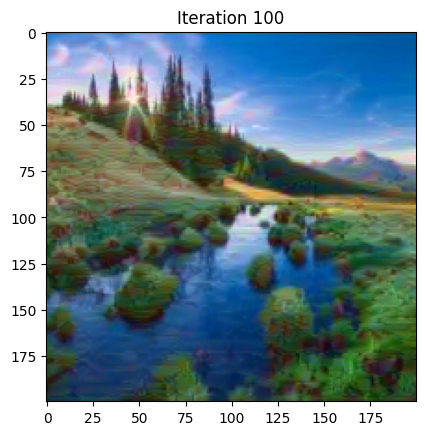

Epoch 150, Total loss: 27973463834624.0


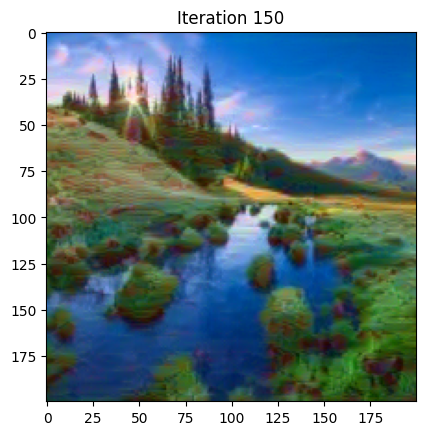

Epoch 200, Total loss: 22006103801856.0


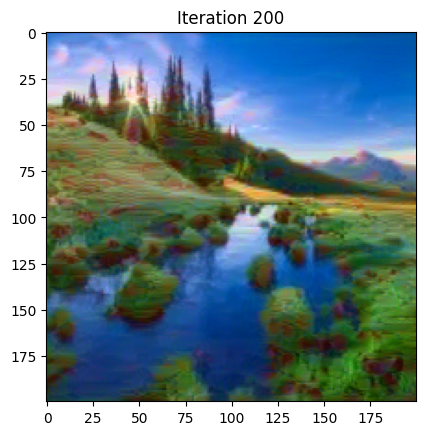

Epoch 250, Total loss: 18482531926016.0


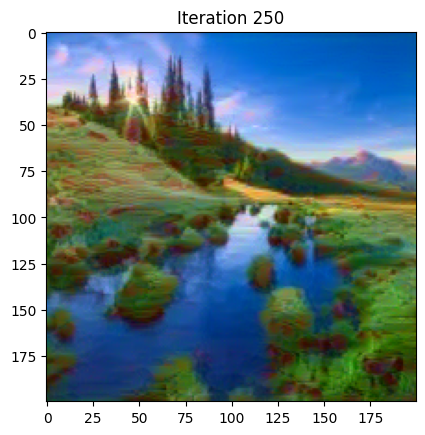

Epoch 300, Total loss: 15800036491264.0


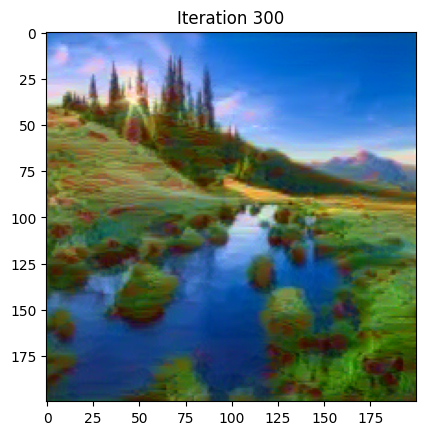

Epoch 350, Total loss: 13575798128640.0


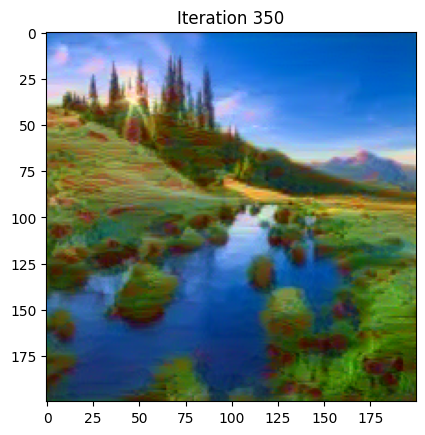

Epoch 400, Total loss: 11689614376960.0


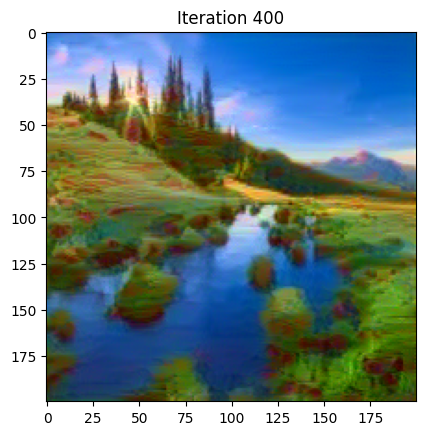

Epoch 450, Total loss: 10085851987968.0


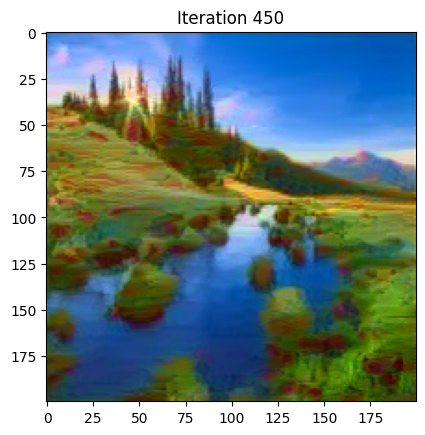

Finished Training!


In [13]:
# Training loop for style transfer
epochs = 500  # Tedad maratabe anjam train (epoch)
for i in range(epochs):
    target_features = get_features(target, vgg)

    # Calculate the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Calculate the style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss

    # Calculate total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print loss and show image every 50 epochs
    if i % 50 == 0:
        print(f'Epoch {i}, Total loss: {total_loss.item()}')
        plt.figure()
        plt.imshow(im_convert(target))
        plt.title(f'Iteration {i}')
        plt.show()

print('Finished Training!')